In [10]:
import os
from dotenv import load_dotenv
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

base_path = os.getenv("BASE_LOCAL_DIR_PATH")

df_data_org = pd.read_json(f"{base_path}project_notebook/ALS/data/test.json", lines=True)
df_data_org.head()

,id,user_id,item_id,join
0,0,0,0,0
1,1,0,1,0
2,2,0,1,0
3,3,0,0,0
4,4,0,1,0


## Preprocessing dataset

#### make score data 
> count of user's select /count of provided events

제공 대비 선택 확률을 기반으로 user별로 item에 대한 `선택 확률`로서 추정.

#### split segments of users
1. n개 이상 user에게 동시에 제공된 이력이 있는 item 내역 추출
2. 각 user별로 해당 item에 대한 경험 정도를 합집합/교집합으로 나눠 유사도를 측정
    - 선택 집합 유사도 측정 방법: *cosine similarity*
    - 선택 아이템의 선호에 대한 유사도 측정 방법: *euclidean distance*
3. *cosine similarity & euclidean distance* 유사도 기반 군집화 알고리즘을 통해 segments 분리
    - *상세 내용 미정*

## Make score data

In [59]:
df_data = df_data_org.copy()

def get_count(value):
    res = dict()
    res['apply_cnt'] = value['id'].count()
    res['join_cnt'] = value['join'].sum()
    res['reject_cnt'] = res['apply_cnt'] - res['join_cnt']
    res['ratio'] = res['join_cnt'] / res['apply_cnt']
    return pd.Series(res, index=res.keys())

df_grouped = df_data.groupby(['user_id', 'item_id']).apply(get_count)
df_grouped.reset_index(inplace=True)
df_grouped

,user_id,item_id,apply_cnt,join_cnt,reject_cnt,ratio
0,0,0,3.0,0.0,3.0,0.000
1,0,1,3.0,0.0,3.0,0.000
2,0,2,2.0,1.0,1.0,0.500
3,0,3,8.0,1.0,7.0,0.125
4,0,7,5.0,1.0,4.0,0.200
...,...,...,...,...,...,...
28497,69,1930,1.0,0.0,1.0,0.000
28498,69,1931,3.0,0.0,3.0,0.000
28499,69,1932,1.0,0.0,1.0,0.000
28500,69,1935,2.0,0.0,2.0,0.000


## Make sample data of items

In [20]:
df_items = df_data[['item_id', 'user_id']].groupby(['item_id']).nunique().reset_index()
df_items

,item_id,user_id
0,0,3
1,1,2
2,2,1
3,3,5
4,4,20
...,...,...
1949,1949,2
1950,1950,1
1951,1951,3
1952,1952,5


<AxesSubplot: >

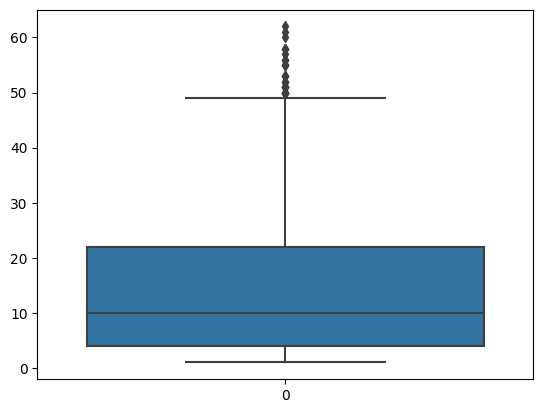

In [215]:
sns.boxplot(df_items['user_id'])

In [33]:
# filtering items where provided count >10
sample_items = list(df_items.loc[df_items['user_id']>10, "item_id"])
df_grouped = df_grouped.loc[df_grouped['item_id'].isin(sample_items)]

## Apply cosine similarity & euclidean distance

### cosine similarity

In [99]:
def make_group(value):
    res = dict()
    data = value.to_dict(orient='records')
    for row in data:
        res[row['item_id']] = row['ratio']
    return res

cos_records = df_grouped.groupby('user_id').apply(make_group)
cos_records = cos_records.to_dict()

In [265]:
def get_cosine_similarity(target:dict, check:dict, mode:str ="full"):
    if mode == "full":
        full_items = set(list(target.keys()) + list(check.keys()))
    elif mode == "intersection":
        full_items = set(list(target.keys())).intersection(list(check.keys()))
        if full_items == None:
            return None
    list_target = list()
    list_check = list()
    for idx in full_items:
        if target.get(idx) == None:
            list_target.append(0)
        else:
            if target.get(idx) >=0.5:
                list_target.append(1)
            else:
                list_target.append(-1)
        
        if check.get(idx) == None:
            list_check.append(0)
        else:
            if check.get(idx) >=0.5:
                list_check.append(1)
            else:
                list_check.append(-1)

    return np.dot(list_target,list_check)/( np.linalg.norm(list_target)*np.linalg.norm(list_check))


#### full set

<AxesSubplot: >

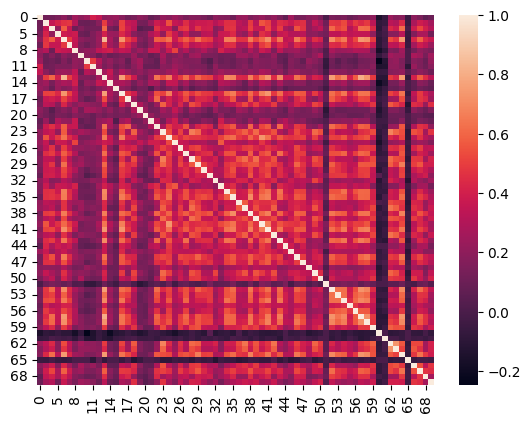

In [102]:
res_data = dict()
for target_idx, target_user in cos_records.items():
    check_data =dict()
    for check_idx, check_user in cos_records.items():
        check_data[check_idx] = get_cosine_similarity(target_user, check_user)
    res_data[target_idx] = check_data

cos_full = pd.DataFrame(res_data)
sns.heatmap(cos_full)

#### intersection set

/var/folders/5v/97lsv0mn5_zf34hm9v9g4_kc0000gn/T/ipykernel_3777/52863769.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(list_target,list_check)/( np.linalg.norm(list_target)*np.linalg.norm(list_check))


<AxesSubplot: >

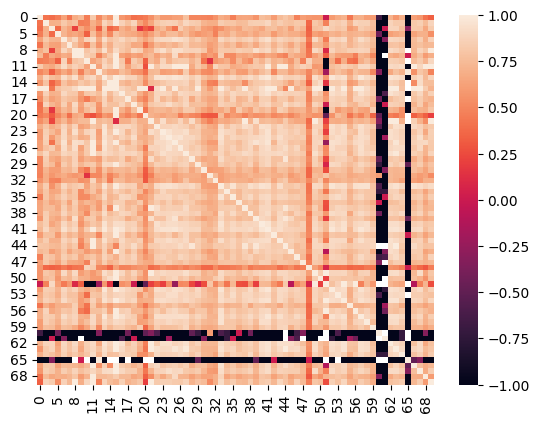

In [289]:
res_cos = dict()
for target_idx, target_user in cos_records.items():
    check_cos =dict()
    for check_idx, check_user in cos_records.items():
        check_cos[check_idx] = get_cosine_similarity(target_user, check_user, mode='intersection')
    res_cos[target_idx] = check_cos

cos_inter = pd.DataFrame(res_cos)
sns.heatmap(cos_inter)

In [267]:
cos_inter

,0,3,4,5,6,7,8,9,10,11,...,60,61,62,63,64,65,66,67,68,69
0,1.000000,0.409091,0.388889,0.458333,0.627907,0.416667,0.674419,0.739130,0.448276,0.826087,...,-0.666667,-1.000000,0.704918,0.574468,0.690141,-1.000000,0.615385,0.576923,0.407407,0.333333
3,0.409091,1.000000,0.688073,0.696970,0.819495,0.740000,0.780488,0.454545,0.473684,0.692308,...,-1.000000,-1.000000,0.868852,0.821782,0.820408,-1.000000,0.820000,0.850932,0.744966,0.876923
4,0.388889,0.688073,1.000000,0.382609,0.719178,0.625468,0.216783,0.655172,0.533333,0.652174,...,-1.000000,0.000000,0.875519,0.868852,0.776173,-0.333333,0.815534,0.807580,0.653061,0.834711
5,0.458333,0.696970,0.382609,1.000000,0.716475,0.625000,0.650000,0.600000,0.333333,0.764706,...,-0.428571,-1.000000,0.612903,0.657895,0.690141,-1.000000,0.626667,0.702128,0.689922,0.531915
6,0.627907,0.819495,0.719178,0.716475,1.000000,0.784431,0.889655,0.680000,0.870968,0.916667,...,-1.000000,-0.333333,0.893175,0.876923,0.858757,-1.000000,0.756944,0.839080,0.679775,0.864198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-1.000000,-1.000000,-0.333333,-1.000000,-1.000000,-1.000000,NaN,0.000000,NaN,-1.000000,...,NaN,NaN,-1.000000,-1.000000,-1.000000,1.000000,-0.500000,-0.333333,-1.000000,-1.000000
66,0.615385,0.820000,0.815534,0.626667,0.756944,0.741379,0.722222,0.666667,0.750000,1.000000,...,-1.000000,-1.000000,0.780702,0.871658,0.785235,-0.500000,1.000000,0.766917,0.672727,0.731544
67,0.576923,0.850932,0.807580,0.702128,0.839080,0.775510,0.873016,0.770492,0.826087,0.888889,...,-1.000000,-1.000000,0.907173,0.911111,0.854214,-0.333333,0.766917,1.000000,0.671329,0.837838
68,0.407407,0.744966,0.653061,0.689922,0.679775,0.722892,0.803922,0.600000,0.714286,1.000000,...,-0.333333,-1.000000,0.661972,0.750000,0.717452,-1.000000,0.672727,0.671329,1.000000,0.600000


### euclidean distance

#### intersection set

In [167]:
def make_group_euc(value):
    return dict(zip(value['item_id'], value['score']))


df_euc = df_grouped.copy()
df_euc['score'] = df_euc['join_cnt'] - df_euc['reject_cnt']

df_euc = df_euc.groupby(by='user_id').apply(make_group_euc)

user_id
0     {7: -3.0, 8: -1.0, 10: -8.0, 11: 4.0, 13: 0.0,...
3     {4: -2.0, 5: -5.0, 7: -1.0, 10: -2.0, 13: -1.0...
4     {4: -1.0, 5: -7.0, 7: -4.0, 8: 1.0, 10: -3.0, ...
5     {5: -3.0, 7: -4.0, 10: -2.0, 13: -1.0, 14: 1.0...
6     {4: -8.0, 5: -9.0, 7: -23.0, 8: -4.0, 10: -4.0...
                            ...                        
65             {229: 6.0, 537: 6.0, 830: 6.0, 917: 6.0}
66    {8: -1.0, 11: -3.0, 16: -7.0, 19: -2.0, 34: -5...
67    {8: -4.0, 11: -2.0, 16: -7.0, 24: -3.0, 34: -7...
68    {11: -1.0, 16: -2.0, 19: -1.0, 25: 1.0, 34: -3...
69    {11: -1.0, 16: -4.0, 19: -1.0, 34: -2.0, 41: -...
Length: 68, dtype: object

In [260]:
def get_euclidean(target:dict, check:dict):
    intersection_items = set(list(target.keys())).intersection(list(check.keys()))
    if intersection_items == None:
        return None
    list_target = list()
    list_check = list()
    for idx in intersection_items:
        list_target.append(target.get(idx))
        list_check.append(check.get(idx))
    return np.linalg.norm(np.array(list_target) - np.array(list_check))

In [261]:
res_euc = dict()
for target_idx in df_euc.keys():
    res_euc_check = dict()
    for check_idx in df_euc.keys():
        res_euc_check[check_idx] = get_euclidean(df_euc[target_idx], df_euc[check_idx])
    res_euc[target_idx] = res_euc_check
euc_inter = pd.DataFrame(res_euc)

<AxesSubplot: >

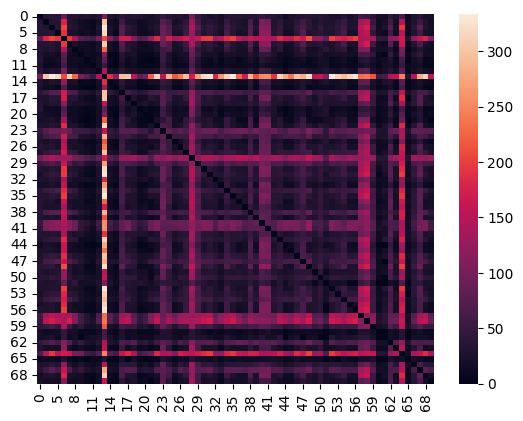

In [288]:
euc_inter = pd.DataFrame(res_euc)
sns.heatmap(euc_inter)

## Make table of sets

In [290]:
cos_inter['user_id'] = cos_inter.index
cos_inter = pd.melt(cos_inter, id_vars='user_id')
cos_inter.dropna(inplace=True)
cos_inter.index = cos_inter.apply(lambda x: f"{x['user_id']}-{x['variable']}", axis=1)

euc_inter['user_id'] = euc_inter.index
euc_inter = pd.melt(euc_inter, id_vars='user_id')
euc_inter.index = euc_inter.apply(lambda x: f"{x['user_id']}-{x['variable']}", axis=1)

In [291]:
df_score = pd.merge(
    cos_inter[['value']],
    euc_inter[['value']],
    left_index=True,
    right_index=True,
    how='inner',
    suffixes=("_cos", "_euc")
)

df_score['user_set'] = df_score.index
df_score[['user_1', 'user_2']]=df_score['user_set'].str.split("-", expand=True)



In [293]:
df_score.reset_index(inplace=True)
df_score.drop(df_score.loc[df_score['user_1'] == df_score['user_2']].index, inplace=True)

In [294]:
print(f"max: {df_score['value_euc'].max()}")
print(f"min: {df_score['value_euc'].min()}")

max: 333.71095277200595
min: 0.0


In [301]:
# apply minmax scaler to df_score[['value_euc', 'value_cos']]
euc_min = df_score['value_euc'].min()
euc_max = df_score['value_euc'].max()


df_score['value_cos_transformed'] = (df_score['value_cos']+1)/2
df_score['value_euc_transformed'] = df_score['value_euc'].apply(lambda x: (x-euc_min) / (euc_max - euc_min))

# convert value
df_score['value_euc_transformed'] = 1-df_score['value_euc_transformed']
df_score


,index,value_cos,value_euc,user_set,user_1,user_2,value_cos_transformed,value_euc_transformed
1,3-0,0.409091,32.357379,3-0,3,0,0.704545,0.903038
2,4-0,0.388889,34.957117,4-0,4,0,0.694444,0.895247
3,5-0,0.458333,32.741411,5-0,5,0,0.729167,0.901887
4,6-0,0.627907,81.406388,6-0,6,0,0.813953,0.756057
5,7-0,0.416667,32.280025,7-0,7,0,0.708333,0.903270
...,...,...,...,...,...,...,...,...
4580,64-69,0.833333,139.212068,64-69,64,69,0.916667,0.582836
4581,65-69,-1.000000,9.000000,65-69,65,69,0.000000,0.973031
4582,66-69,0.731544,34.365681,66-69,66,69,0.865772,0.897020
4583,67-69,0.837838,67.764297,67-69,67,69,0.918919,0.796937


<AxesSubplot: xlabel='value_euc_transformed'>

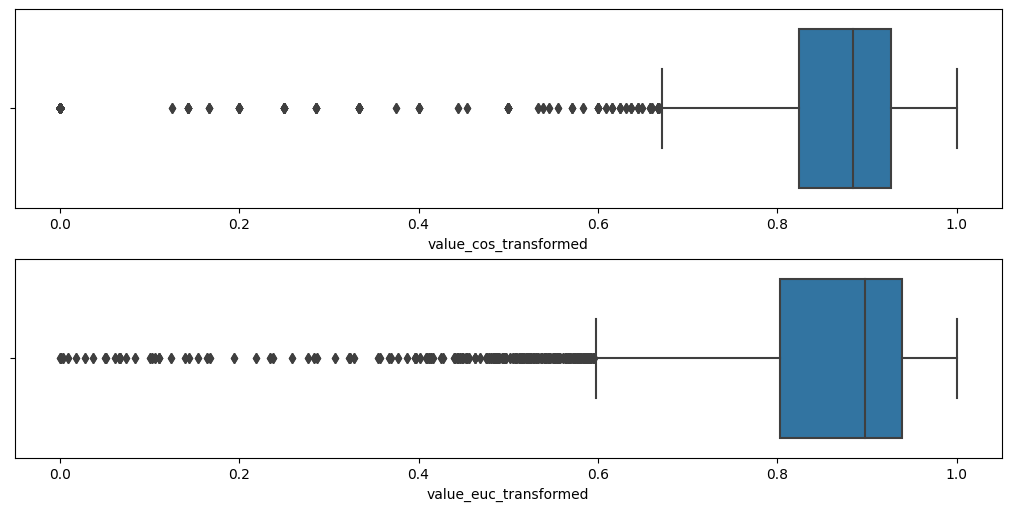

In [312]:
fig, axes = plt.subplots(2,1, figsize=(10,5), constrained_layout=True)
sns.boxplot(ax=axes[0],x=df_score['value_cos_transformed'])
sns.boxplot(ax=axes[1],x=df_score['value_euc_transformed'])

<AxesSubplot: xlabel='value_cos_transformed', ylabel='value_euc_transformed'>

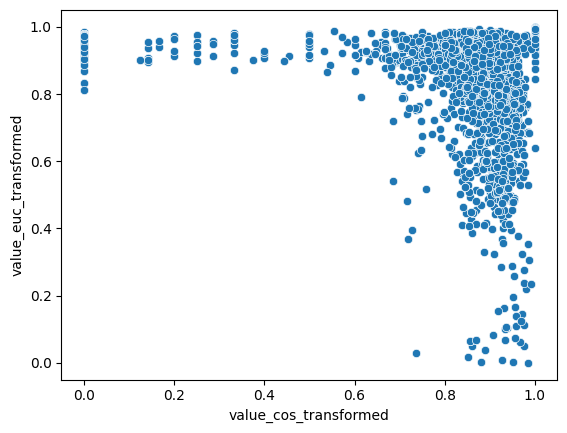

In [313]:
sns.scatterplot(data=df_score, x="value_cos_transformed", y='value_euc_transformed')

In [316]:
df_test = df_data_org.loc[df_data_org['user_id'].isin([65,69])]
df_test.gropuby(['user_id', 'item_id']).apply()

,id,user_id,item_id,join
79367,79367,65,537,1
79369,79369,65,917,1
79370,79370,65,622,1
79453,79453,65,830,1
79457,79457,65,229,1
...,...,...,...,...
94925,94925,65,917,1
94926,94926,65,229,1
94937,94937,65,622,1
94955,94955,65,537,1


# test

In [320]:
df_test = df_data_org.loc[df_data_org['user_id'].isin([65,69])]
df_test.groupby(['item_id','user_id']).apply(get_count)

,,apply_cnt,join_cnt,reject_cnt,ratio
item_id,user_id,,,,
11,69,1.0,0.0,1.0,0.0
16,69,4.0,0.0,4.0,0.0
19,69,1.0,0.0,1.0,0.0
34,69,2.0,0.0,2.0,0.0
41,69,3.0,0.0,3.0,0.0
...,...,...,...,...,...
1930,69,1.0,0.0,1.0,0.0
1931,69,3.0,0.0,3.0,0.0
1932,69,1.0,0.0,1.0,0.0


In [325]:
test_1 = df_test[['item_id', 'user_id']].groupby("item_id").nunique().reset_index()
test_1.sort_values(by='user_id', ascending=False)

,item_id,user_id
75,830,2
0,11,1
149,1633,1
139,1505,1
140,1506,1
...,...,...
77,833,1
78,834,1
79,850,1
80,862,1


In [326]:
df_test.loc[df_test['item_id']==830]

,id,user_id,item_id,join
79453,79453,65,830,1
83027,83027,65,830,1
84623,84623,65,830,1
87250,87250,65,830,1
90345,90345,69,830,0
90346,90346,69,830,0
90424,90424,69,830,0
91685,91685,65,830,1
95197,95197,65,830,1


In [328]:
df_score.loc[df_score['user_set'].str.contains("69")]

,index,value_cos,value_euc,user_set,user_1,user_2,value_cos_transformed,value_euc_transformed
67,69-0,0.333333,21.748563,69-0,69,0,0.666667,0.934828
135,69-3,0.876923,16.124515,69-3,69,3,0.938462,0.951681
203,69-4,0.834711,19.467922,69-4,69,4,0.917355,0.941662
271,69-5,0.531915,17.720045,69-5,69,5,0.765957,0.946900
339,69-6,0.864198,108.926581,69-6,69,6,0.932099,0.673590
...,...,...,...,...,...,...,...,...
4580,64-69,0.833333,139.212068,64-69,64,69,0.916667,0.582836
4581,65-69,-1.000000,9.000000,65-69,65,69,0.000000,0.973031
4582,66-69,0.731544,34.365681,66-69,66,69,0.865772,0.897020
4583,67-69,0.837838,67.764297,67-69,67,69,0.918919,0.796937


In [331]:
df_score.loc[df_score['user_1']=="69"].sort_values(by="value_cos_transformed", ascending=False)

,index,value_cos,value_euc,user_set,user_1,user_2,value_cos_transformed,value_euc_transformed
676,69-11,1.000000,4.582576,69-11,69,11,1.000000e+00,0.986268
474,69-8,1.000000,12.083046,69-8,69,8,1.000000e+00,0.963792
1351,69-21,1.000000,2.236068,69-21,69,21,1.000000e+00,0.993299
2167,69-33,0.916667,9.486833,69-33,69,33,9.583333e-01,0.971572
608,69-10,0.894737,6.782330,69-10,69,10,9.473684e-01,0.979676
...,...,...,...,...,...,...,...,...
3384,69-51,0.250000,24.372115,69-51,69,51,6.250000e-01,0.926966
1284,69-20,0.200000,11.958261,69-20,69,20,6.000000e-01,0.964166
4052,69-61,-1.000000,13.000000,69-61,69,61,0.000000e+00,0.961044
4313,69-65,-1.000000,9.000000,69-65,69,65,0.000000e+00,0.973031


In [341]:
test_2 = df_data_org.loc[df_data['user_id'].isin([69,11])].pivot_table(index='item_id', columns='user_id', values='join', aggfunc="sum")

In [344]:
test_2.dropna()

user_id,11,69
item_id,,
16,0.0,0.0
19,0.0,0.0
34,0.0,0.0
41,0.0,0.0
47,0.0,0.0
56,0.0,0.0
68,1.0,0.0
103,0.0,0.0
104,0.0,0.0
